Course: https://www.udemy.com/course/time-series-analysis/

# Section 6: Vector Autoregression

- The data for this course is available at: https://docs.google.com/document/d/1SiG1V325FQ4bqhUFEoXGhkAK89RSS0tplcJBCuivn_s/edit?usp=sharing

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# VARMA
- Use dataset of temperatures in multiple cities

In [2]:
df = pd.read_csv('./data/temperature.csv')
df.head()

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude
0,474376,1,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
1,474377,2,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
2,474378,3,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
3,474379,4,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
4,474380,5,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E


- this data is not formatted in a way that's useful for us to process
- write function to parse date and write out in useful form Y-m-d:

In [3]:
def parse_date(row):
    s = f"{row['year']}-{row['month']}-{row['day']}"
    return datetime.strptime(s,"%Y-%m-%d") # format timestamp from str format

df['Date'] = df.apply(parse_date,axis=1) # works as python map function

- extract temperatures for 2 different cities, e.g. Auckland and Stockholm:

In [4]:
auckland = df[df['City']=='Auckland'].copy().dropna()
stockholm = df[df['City']=='Stockholm'].copy().dropna()

In [5]:
auckland.head()

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude,Date
5,474381,6,1,1853,51.9062,36.9572,Auckland,NEW,New Zealand,36.17S,175.03E,1853-06-01
6,474382,7,1,1853,52.3886,34.5488,Auckland,NEW,New Zealand,36.17S,175.03E,1853-07-01
7,474383,8,1,1853,52.8530,33.5498,Auckland,NEW,New Zealand,36.17S,175.03E,1853-08-01
8,474384,9,1,1853,52.5776,33.6380,Auckland,NEW,New Zealand,36.17S,175.03E,1853-09-01
9,474385,10,1,1853,54.8726,33.9836,Auckland,NEW,New Zealand,36.17S,175.03E,1853-10-01


In [6]:
auckland = df[df['City']=='Auckland'].copy().dropna()
stockholm = df[df['City']=='Stockholm'].copy().dropna()

# keeping only columns we want
auckland = auckland[['Date','AverageTemperatureFahr']].copy()
stockholm = stockholm[['Date','AverageTemperatureFahr']].copy()

# set index to date column
auckland.set_index(auckland['Date'],inplace=True)
auckland.drop('Date',axis=1,inplace=True)
auckland.columns = ['AucklandTemp']

stockholm.set_index(stockholm['Date'],inplace=True)
stockholm.drop('Date',axis=1,inplace=True)
stockholm.columns = ['StockholmTemp']

# peek
auckland.head()

,AucklandTemp
Date,
1853-06-01,51.9062
1853-07-01,52.3886
1853-08-01,52.8530
1853-09-01,52.5776
1853-10-01,54.8726


- Now join both Auckland and Stockholm into vector timeseries format:

In [7]:
joined = auckland.join(stockholm,how='outer') # has some missing data
joined.head()

,AucklandTemp,StockholmTemp
Date,,
1743-11-01,NaN,42.8414
1744-04-01,NaN,36.8888
1744-05-01,NaN,45.1220
1744-06-01,NaN,53.1824
1744-07-01,NaN,60.0260


In [8]:
joined.shape

(3155, 2)

- ~3k rows and 2 columns
- Actually this is a pretty large number of values for VARMA to handle
- Let's choose the last 500 rows instead. Also set the index freq to months

In [9]:
joined_part = joined.iloc[-500:].copy()
joined_part.index.freq = 'MS'

- Now let's see how many missing values remain

In [12]:
joined_part.isna().sum()

AucklandTemp     1
StockholmTemp    4
dtype: int64

- Fill in the missing values by interpolation

In [13]:
joined_part.interpolate(inplace=True)
joined_part.isna().sum() # should now be all 0

AucklandTemp     0
StockholmTemp    0
dtype: int64

- Plot the time series:

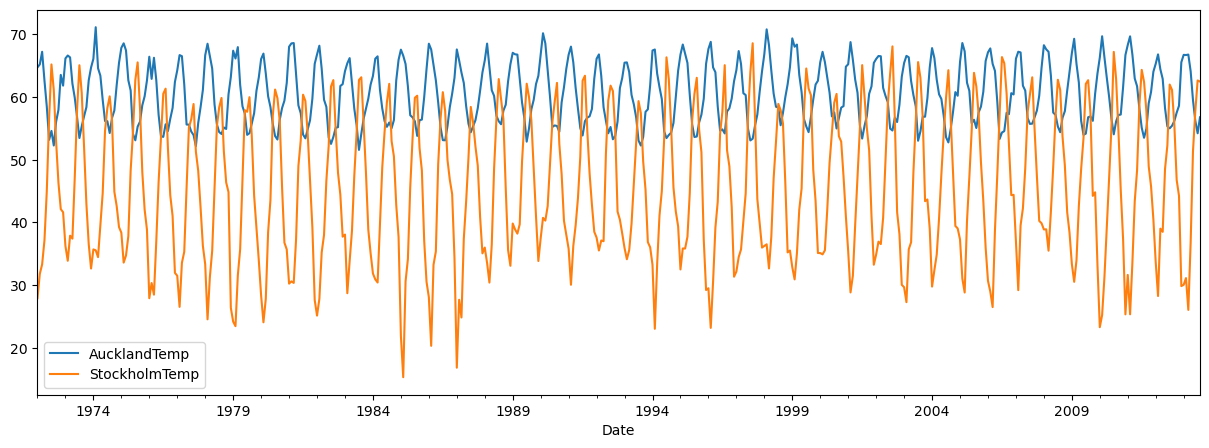

In [14]:
joined_part.plot(figsize=(15,5));

- Split data into train and test

In [15]:
Ntest = 12
train = joined_part.iloc[:-Ntest].copy()
test = joined_part.iloc[-Ntest:].copy()

- Also, temperatures for two cities are not on the same scale so it would perhaps be useful to scale it

In [17]:
# Auckland
scaler_auckland = StandardScaler()
train['ScaledAuckland'] = scaler_auckland.fit_transform(train[['AucklandTemp']])
test['ScaledAuckland'] = scaler_auckland.transform(test[['AucklandTemp']])

# Stockholm
scaler_stockholm = StandardScaler()
train['ScaledStockholm'] = scaler_stockholm.fit_transform(train[['StockholmTemp']])
test['ScaledStockholm'] = scaler_stockholm.transform(test[['StockholmTemp']])

- Put back into original df and check scale by plotting

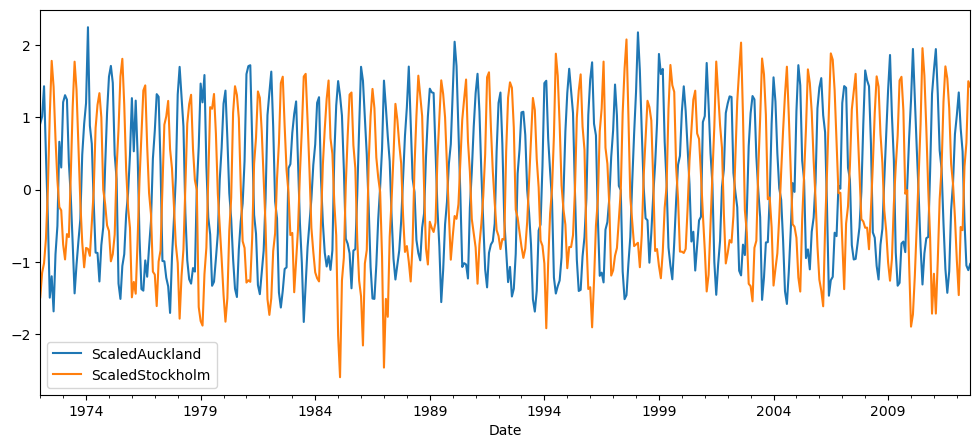

In [19]:
train_idx = joined_part.index <= train.index[-1]
test_idx = joined_part.index > train.index[-1]

# put back in original df
joined_part.loc[train_idx,'ScaledAuckland'] = train['ScaledAuckland']
joined_part.loc[test_idx,'ScaledAuckland'] = test['ScaledAuckland']
joined_part.loc[train_idx,'ScaledStockholm'] = train['ScaledStockholm']
joined_part.loc[test_idx,'ScaledStockholm'] = test['ScaledStockholm']

# plot scaled temps
cols = ['ScaledAuckland','ScaledStockholm']
train[cols].plot(figsize=(12,5));

- Now temps are on the same scale
- Next, plot ACF and PACF for each time series. We can use these to guide our choice for the number of lags in our model

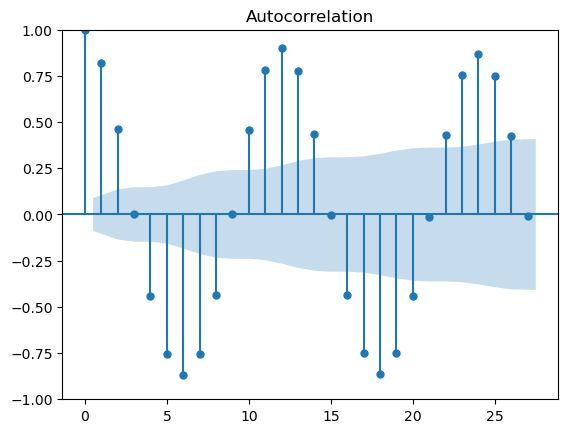

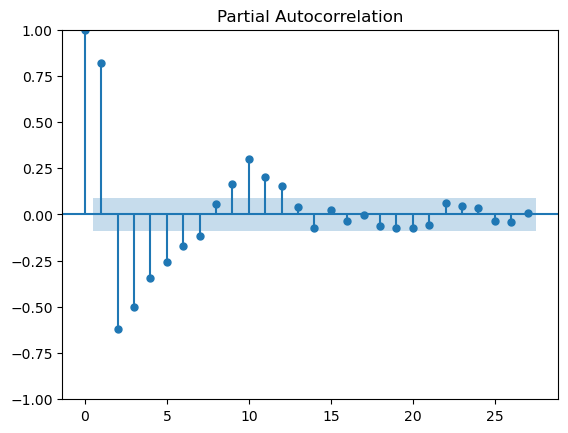

In [22]:
plot_acf(train['ScaledAuckland']);
plot_pacf(train['ScaledAuckland']);

- ACF has strong seasonal pattern since ts itself has strong seasonal pattern
- PACF has similar pattern but lags closer to 0 are more significant

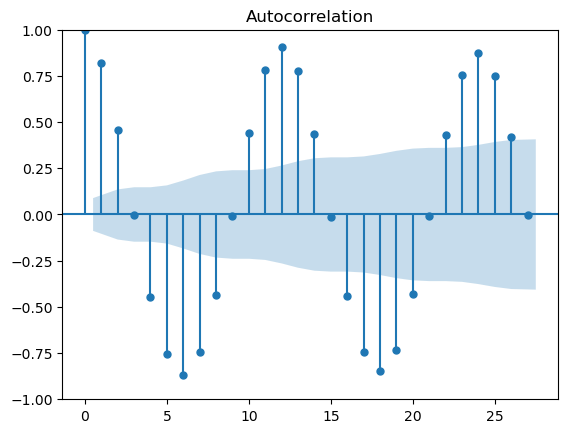

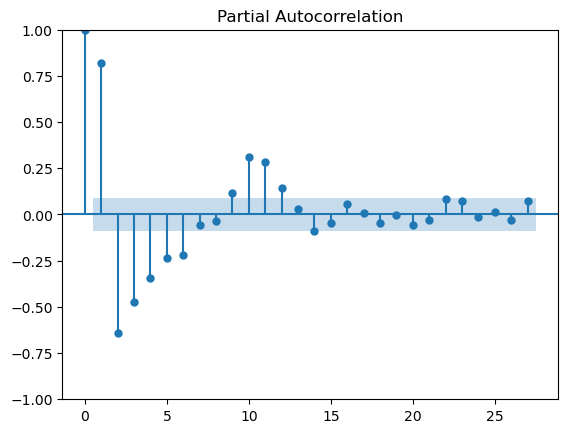

In [23]:
plot_acf(train['ScaledStockholm']);
plot_pacf(train['ScaledStockholm']);

- We see similar patterns as for Auckland
- Create VARMAX object and fit it to time series
    - As instructor, picked `p=10` and `q=10` for no particular reason

In [24]:
t0 = datetime.now() # measure how long it takes
model= VARMAX(train[cols],order=(10,10))
res = model.fit(maxiter=100)
print(f"Duration: {datetime.now()-t0}")

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration: 0:04:33.169256


- Note the warning of identification issues. As pointed out in the notes, this is because VARMA models are not unique. You'll get this if you choose `q!=0`
- Now get the forecast for `Ntest` time steps, the fitted values, and place all back in original time series

In [29]:
fcast = res.get_forecast(Ntest)

# Auckland
joined_part.loc[train_idx,'Train Pred Auckland'] = res.fittedvalues['ScaledAuckland']
joined_part.loc[test_idx,'Test Pred Auckland'] = fcast.predicted_mean['ScaledAuckland']

# Stockholmd
joined_part.loc[train_idx,'Train Pred Stockholm'] = res.fittedvalues['ScaledStockholm']
joined_part.loc[test_idx,'Test Pred Stockholm'] = fcast.predicted_mean['ScaledStockholm']

- Plot (last 100 values to give the plot a reasonable size)

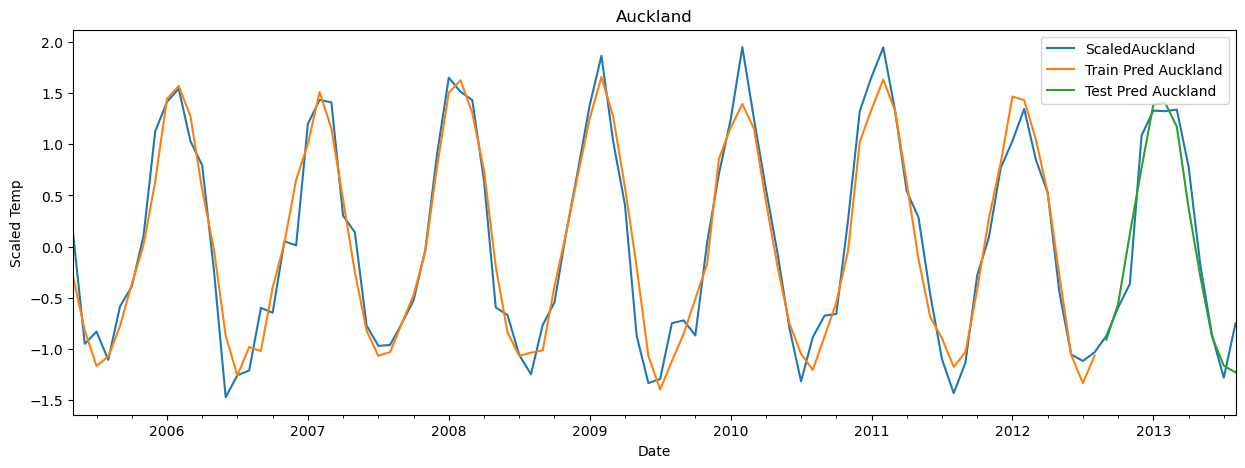

In [32]:
plot_cols = ['ScaledAuckland','Train Pred Auckland','Test Pred Auckland']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15,5));
plt.title('Auckland')
plt.ylabel('Scaled Temp')
plt.show()

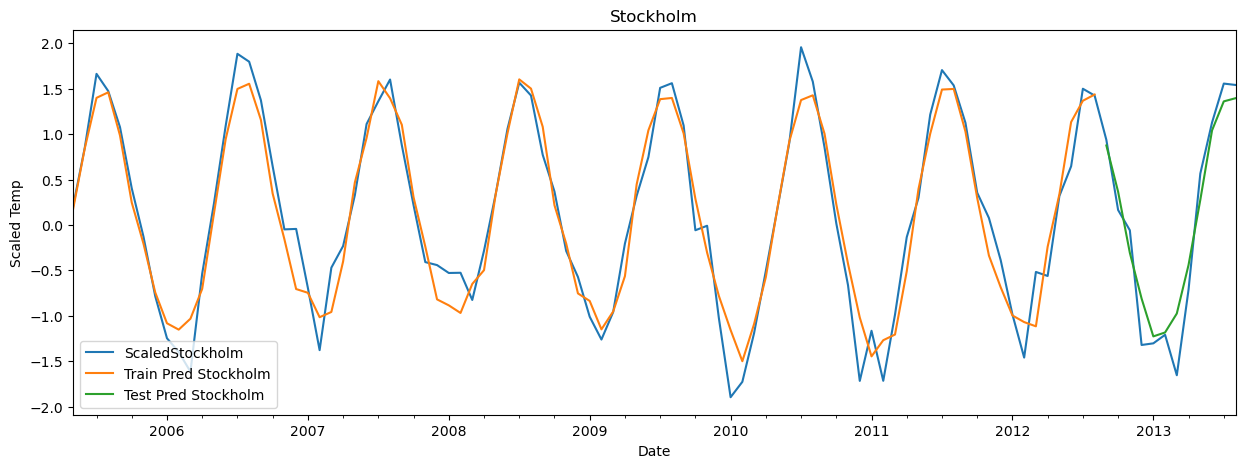

In [35]:
plot_cols = ['ScaledStockholm','Train Pred Stockholm','Test Pred Stockholm']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15,5));
plt.title('Stockholm')
plt.ylabel('Scaled Temp')
plt.show()

- Both in sample and out of sample preds look good
- Check the R^2 of our model

In [37]:
country = 'Auckland'
y_pred = joined_part.loc[train_idx,f'Train Pred {country}']
y_true = joined_part.loc[train_idx,f'Scaled{country}']
print(f"{country} Train R^2: {r2_score(y_true,y_pred)}")

y_pred = joined_part.loc[test_idx,f'Test Pred {country}']
y_true = joined_part.loc[test_idx,f'Scaled{country}']
print(f"{country} Test R^2: {r2_score(y_true,y_pred)}")

Auckland Train R^2: 0.9295013033604304
Auckland Test R^2: 0.9292671890650915


In [38]:
country = 'Stockholm'
y_pred = joined_part.loc[train_idx,f'Train Pred {country}']
y_true = joined_part.loc[train_idx,f'Scaled{country}']
print(f"{country} Train R^2: {r2_score(y_true,y_pred)}")

y_pred = joined_part.loc[test_idx,f'Test Pred {country}']
y_true = joined_part.loc[test_idx,f'Scaled{country}']
print(f"{country} Test R^2: {r2_score(y_true,y_pred)}")

Stockholm Train R^2: 0.9246695351340106
Stockholm Test R^2: 0.9312970082806165


- Next, let's try VAR

# VAR
- Create VAR object and pass in the training data

In [39]:
model = VAR(train[cols]) # don't need to pass in p

- Call `selec_order` function to see what different information criteria would select
    - Arbitrarily chose `maxlags=15`

In [41]:
lag_order_results = model.select_order(maxlags=15)
lag_order_results # returns LagOrderResults object

- Print out selected order attributes
    - This gives a dictionary with key = information criterion chosen and value = lag order chosen if you use this criterion
    - Notice that they do not all agree

In [42]:
lag_order_results.selected_orders

{'aic': 12, 'bic': 6, 'hqic': 11, 'fpe': 12}

- Calling `select_order` does not have an impact in the actual estimation of the model. It should be used only for information
- Now actuall fit (estimate) the model

In [43]:
t0 = datetime.now() # measure how long it takes
results = model.fit(maxlags=15,ic='aic')
print(f"Duration: {datetime.now()-t0}")

Duration: 0:00:00.159326


- Notice how quickly this train, specially when compared to VARMA above
- Get the lag order chosen by AIC
    - This is stored in an attributed `k_ar`

In [45]:
lag_order = results.k_ar
lag_order

12

- In order to forecast, we need to also pass in the prior values of the time series. This is different from other models which only allow you to forecast after the data you've passed into the constructor

In [46]:
prior = train.iloc[-lag_order:][cols].to_numpy()
fcast = results.forecast(prior,Ntest)

- Now put back into original df

In [53]:
country = 'Auckland'
joined_part.loc[train_idx,f'Train Pred {country}'] = results.fittedvalues[f'Scaled{country}']
joined_part.loc[test_idx,f'Test Pred {country}'] = fcast[:,0]

country = 'Stockholm'
joined_part.loc[train_idx,f'Train Pred {country}'] = results.fittedvalues[f'Scaled{country}']
joined_part.loc[test_idx,f'Test Pred {country}'] = fcast[:,1] # notice index change here

- Plot last 100 values

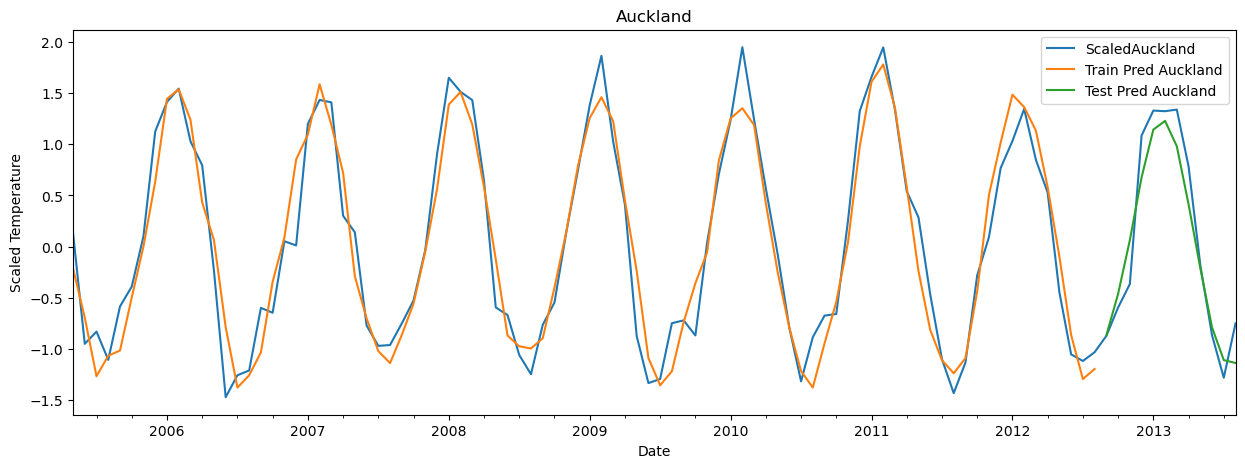

In [51]:
country = 'Auckland'
plot_cols = [f'Scaled{country}',f'Train Pred {country}',f'Test Pred {country}']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15,5));
plt.title(f'{country}')
plt.ylabel('Scaled Temperature')
plt.show()

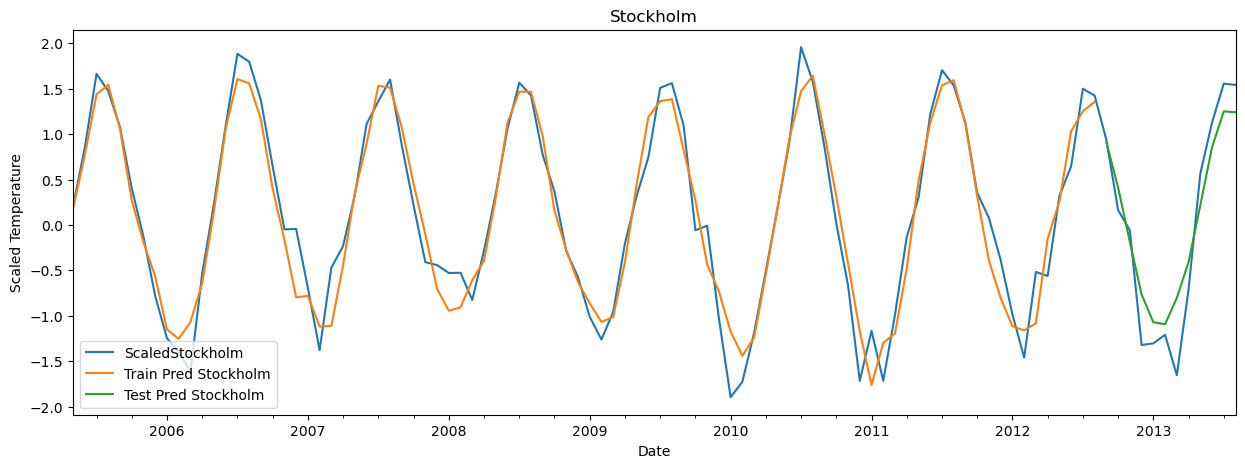

In [54]:
country = 'Stockholm'
plot_cols = [f'Scaled{country}',f'Train Pred {country}',f'Test Pred {country}']
joined_part.iloc[-100:][plot_cols].plot(figsize=(15,5));
plt.title(f'{country}')
plt.ylabel('Scaled Temperature')
plt.show()

- Compute R^2:

In [57]:
country = 'Auckland'
y_pred = joined_part.loc[train_idx,f'Train Pred {country}']
y_true = joined_part.loc[train_idx,f'Scaled{country}']
y_true = y_true.iloc[lag_order:] # must ignore first n lags since AR model needs at least n lags to fit onto
y_pred = y_pred.iloc[lag_order:]
print(f"{country} Train R^2: {r2_score(y_true,y_pred)}")

y_pred = joined_part.loc[test_idx,f'Test Pred {country}']
y_true = joined_part.loc[test_idx,f'Scaled{country}']
print(f"{country} Test R^2: {r2_score(y_true,y_pred)}")

Auckland Train R^2: 0.921070700106029
Auckland Test R^2: 0.9233643831340894


In [59]:
country = 'Stockholm'
y_pred = joined_part.loc[train_idx,f'Train Pred {country}']
y_true = joined_part.loc[train_idx,f'Scaled{country}']
y_true = y_true.iloc[lag_order:] # must ignore first n lags since AR model needs at least n lags to fit onto
y_pred = y_pred.iloc[lag_order:]
print(f"{country} Train R^2: {r2_score(y_true,y_pred)}")

y_pred = joined_part.loc[test_idx,f'Test Pred {country}']
y_true = joined_part.loc[test_idx,f'Scaled{country}']
print(f"{country} Test R^2: {r2_score(y_true,y_pred)}")

Stockholm Train R^2: 0.9267030553588321
Stockholm Test R^2: 0.8930437688204876


- For Auckland, forecast is not as good as VARMA
- For Stockholm, forecast is not as good as VARMA
- In order to perform a true model comparison we need a baseline... let's try ARIMA

# ARIMA (as baseline)
- Need to apply ARIMA separately to each time series in dataset individually
- Try ARIMA models with `p=10` and `q=10` as before
    - These will have less parameters than VAR and VARMA since there are no cross-terms

In [60]:
from statsmodels.tsa.arima.model import ARIMA

In [62]:
cols

['ScaledAuckland', 'ScaledStockholm']

In [78]:
for col in cols:
    model = ARIMA(train[col],order=(10,0,10))
    res = model.fit()
    fcast = res.get_forecast(Ntest)
    print(f'{col} Train R^2: {r2_score(joined_part.loc[train_idx,col],res.fittedvalues)}')
    print(f'{col} Test R^2: {r2_score(joined_part.loc[test_idx,col],fcast.predicted_mean)}')

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ScaledAuckland Train R^2: 0.9213763062527798
ScaledAuckland Test R^2: 0.9380737936253666
ScaledStockholm Train R^2: 0.9207504130043412
ScaledStockholm Test R^2: 0.9484607195104402


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


- For both cities, the R^2 is better in ARIMA
- Train score is smaller but Test score is larger
    - These models overfit less
    - Makes sense since both cities are so far apart, there may be no correlation between their temperatures and any correlation we find may be due to noise. Using ARIMA eliminates the cross-terms which removes this possibility
- It's best to check which model does best and outperforms the others. In this case the baseline is the better choice

# VARMA econometrics
- Look at another example of VARMA in Python with a more complicated dataset
- Econometrics is probably the most common application of VAR 
- Prevailing wisdom tells us there should be some temporal correlation between time series

In [79]:
from statsmodels.tsa.stattools import adfuller

In [80]:
df = pd.read_excel('./data/us_macro_quarterly.xlsx')
df.head()

C:\ProgramData\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
0,1957:01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1,1957:02,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
2,1957:03,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
3,1957:04,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
4,1958:01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667


- The data is, again, not in a format we typically use
    - Current format: year followed by quarter with : in between. Second number goes from 01 to 04
- Write function to parse date column

In [84]:
def parse_date(data):
    year, quarter = data.split(':')
    month = (int(quarter)-1)*3+1 # turns 01 to January, 02 to April and so on
    s = f"{year}-{month}"
    return datetime.strptime(s,'%Y-%m')

In [82]:
df['Date'] = df['Unnamed: 0'].apply(parse_date)
df.head()

,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL,Date
0,1957:01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667,1957-01-01
1,1957:02,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333,1957-04-01
2,1957:03,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333,1957-07-01
3,1957:04,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000,1957-10-01
4,1958:01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667,1958-01-01


- Now set the Date column as the index for dataframe, clean up, and set freq

In [83]:
df.set_index(df['Date'],inplace=True)
df.drop(['Date','Unnamed: 0'],axis=1,inplace=True)
df.index.freq = 'QS' # quarterly frequency
df.head()

,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
Date,,,,,,,,,
1957-01-01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1957-04-01,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
1957-07-01,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
1957-10-01,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
1958-01-01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667


- For this example we'll look at GDP and term spread

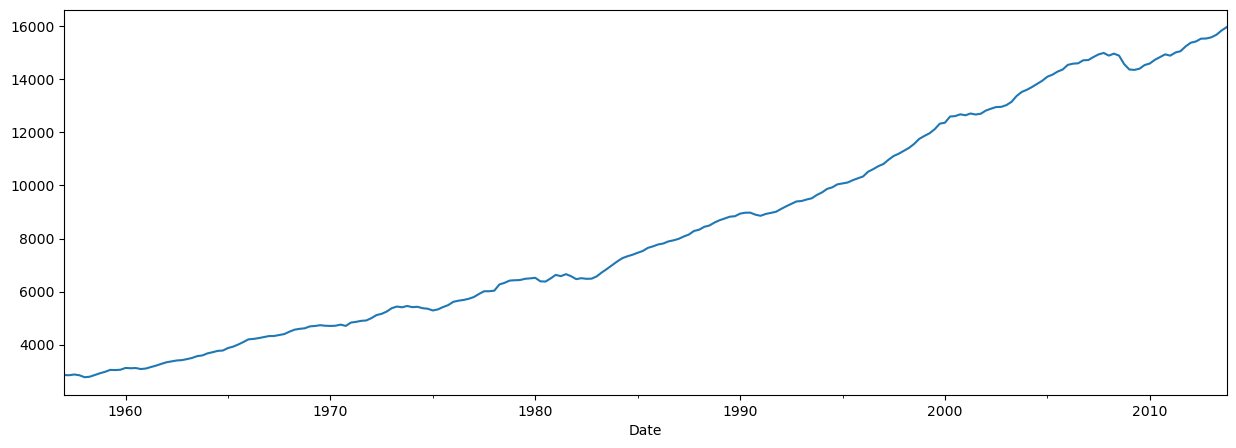

In [85]:
df['GDPC96'].plot(figsize=(15,5));

- This data has a strong trend, i.e no stationary
    - We should difference this column before applying any model
    - In practice, take the log difference and call it 'GDPGrowth'

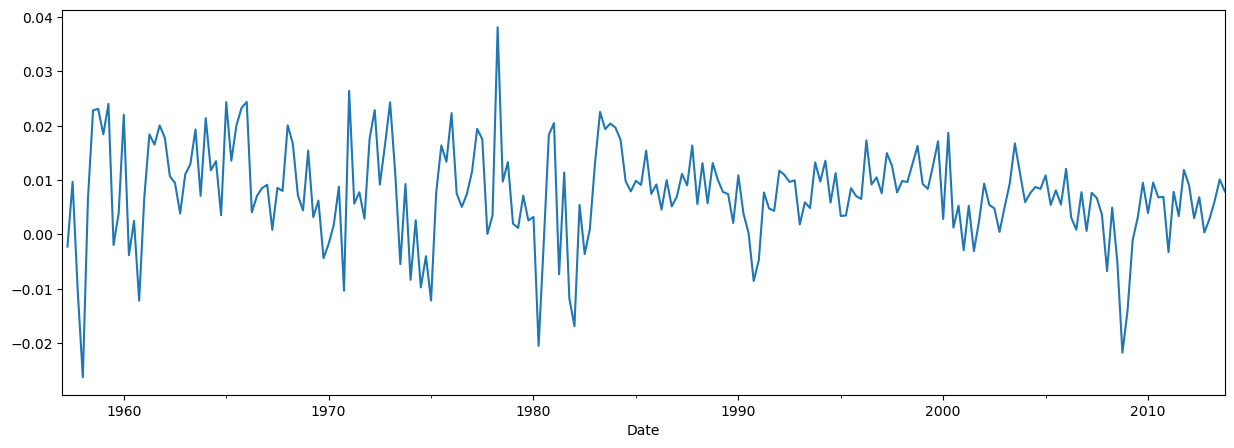

In [88]:
df['GDPGrowth'] = np.log(df['GDPC96']).diff()
df['GDPGrowth'].plot(figsize=(15,5));

- Now compute the "term spread" = long term rate - short term rate 

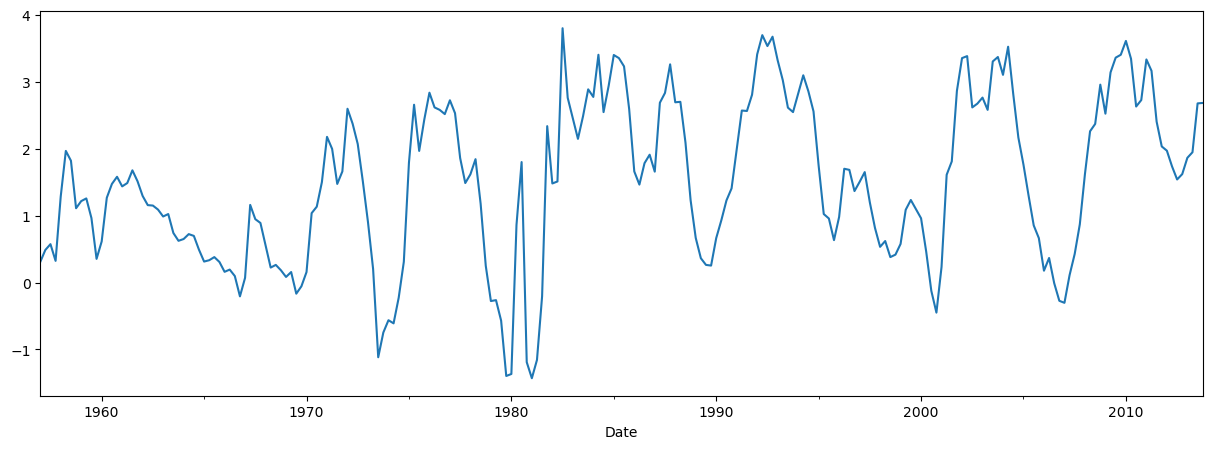

In [90]:
df['TSpread'] = df['GS10'] - df['TB3MS'] # in this case a 10 yr investment vs 3 month investment
df['TSpread'].plot(figsize=(15,5));

- not quite stationary but no clear trend although there seems to be some cyclical pattern
- Define which columns we care about

In [91]:
cols = ['GDPGrowth','TSpread']
df1 = df.iloc[1:][cols].copy() # get rid of first row of data since we used differencing in GDP

- Parameters for fitting and testing

In [92]:
Ntest = 12
train = df1.iloc[:-Ntest].copy()
test = df1.iloc[-Ntest:].copy()

train_idx = df1.index <= train.index[-1]
test_idx = ~train_idx

- Scale data
    - Just overwrite original values since we won't be using them anyways

In [93]:
scaler = StandardScaler()
train[cols] = scaler.fit_transform(train)
test[cols] = scaler.transform(test)

# replace in df1 as well
df1.loc[train_idx,:] = train
df1.loc[test_idx,:] = test

- Plot ACF and PACF for GDPGrowth

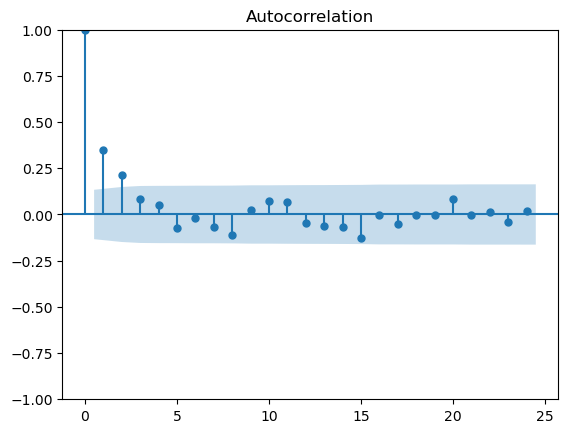

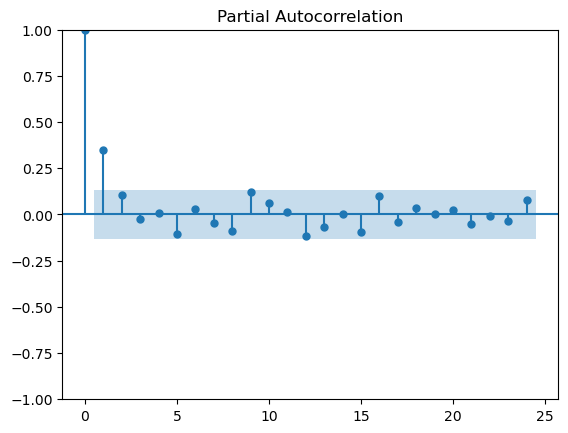

In [94]:
plot_acf(train['GDPGrowth']);
plot_pacf(train['GDPGrowth']);

- Based onGDPGrowth alone
    - ACF seems to suggest a small q value
    - PACF seems to suggest a small p value
- However, these plots are not exactly what you need to determine p and q since they do not consider cross-terms. We're only using them as a very rough guide to give us some idea
    - In practice, do a grid search for best values based on information criteria we care about
- Plot ACF and PACF for TSpread

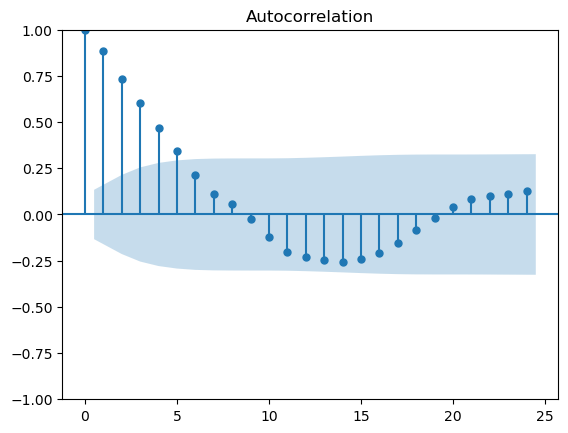

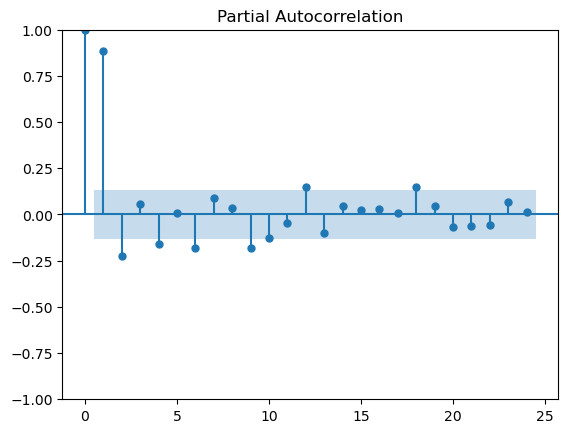

In [96]:
plot_acf(train['TSpread']);
plot_pacf(train['TSpread']);

- ACF suggests signal has a cyclical pattern - which is what we observed
- In PACF, note that quite a few lags are significant (outside CI blue region) up to a pretty high order
- Check for stationarity with ADF test:
    - Recall p-value is second element in the tuple

In [97]:
adfuller(train['GDPGrowth'])

(-7.446639654625579,
 5.8148965809139116e-11,
 1,
 213,
 {'1%': -3.461429147102264,
  '5%': -2.875206950587861,
  '10%': -2.5740544497344002},
 512.854231063742)

In [98]:
adfuller(train['TSpread'])

(-4.001020795475581,
 0.001405175490749354,
 12,
 202,
 {'1%': -3.4631437906252636,
  '5%': -2.8759570379821047,
  '10%': -2.574454682874228},
 246.36949884218734)

- Both p-values are below a reasonable  p = 5%, so we consider them stationary
- Set p and q (somewhat arbitrarily):
    - p = 18
    - q = 1
- High value for p since PACF for term spread suggested a large p
- Now fit VARMAX model as before:

In [99]:
p = 18
q = 1

t0 = datetime.now()
model = VARMAX(train, order=(p,q))
res = model.fit(maxiter=100)
print(f'Duration: {datetime.now()-t0}')

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration: 0:00:54.273625


- Get forecast and fill out dataframe

In [103]:
fcast = res.get_forecast(Ntest)

df1.loc[train_idx,'Train Pred GDPGrowth'] = res.fittedvalues['GDPGrowth']
df1.loc[test_idx,'Test Pred GDPGrowth'] = fcast.predicted_mean['GDPGrowth']

df1.loc[train_idx,'Train Pred TSpread'] = res.fittedvalues['TSpread']
df1.loc[test_idx,'Test Pred TSpread'] = fcast.predicted_mean['TSpread']

- Plot last 100 points

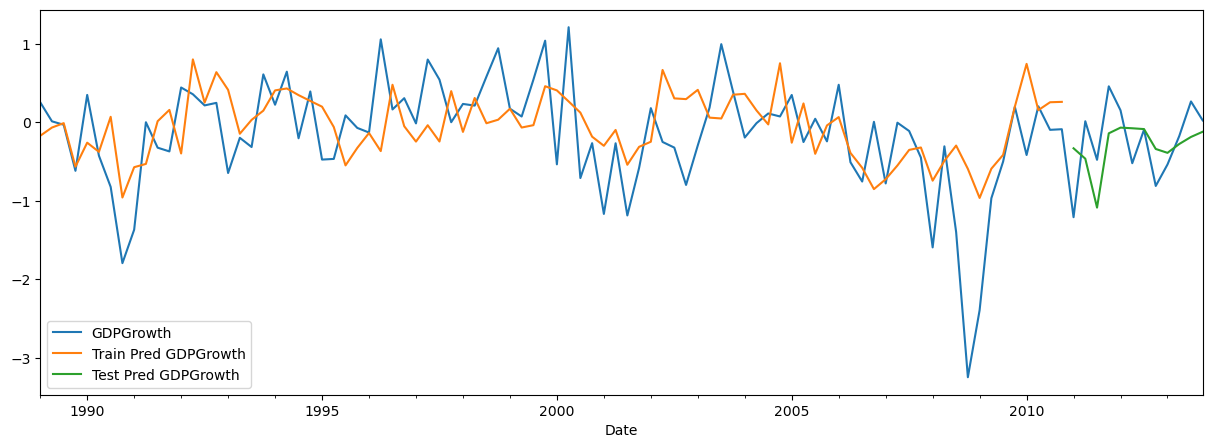

In [107]:
plot_cols = ['GDPGrowth','Train Pred GDPGrowth','Test Pred GDPGrowth']
df1.iloc[-100:][plot_cols].plot(figsize=(15,5));

- Both train and test fit are not particularly good (specially when compared to previous example)
- Seems to have the most trouble predicting the most exdtreme values (similar to what we've seen in stock price analysis) but it goes in the same direction 

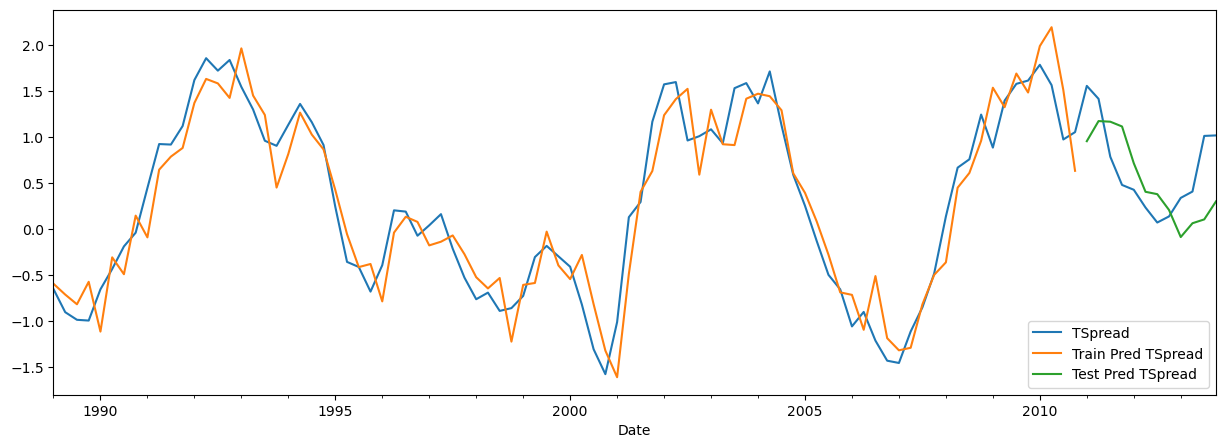

In [108]:
plot_cols = ['TSpread','Train Pred TSpread','Test Pred TSpread']
df1.iloc[-100:][plot_cols].plot(figsize=(15,5));

- In this case the train fitted values are good but are lagging by one step. This is typical of a trend with noise
- Compute R^2 for both train and test set for each column:

In [109]:
for col in cols:
    y_true = df1.loc[train_idx,col]
    y_pred = res.fittedvalues[col]
    print(f'Train R^2: {r2_score(y_true,y_pred)}')
    
    y_true = df1.loc[test_idx,col]
    y_pred = fcast.predicted_mean[col]
    print(f'Test R^2: {r2_score(y_true,y_pred)}')

Train R^2: 0.27652114958017704
Test R^2: 0.0360048187209856
Train R^2: 0.87366369582607
Test R^2: -0.04539326914115893


- As expected for GDPGrowth, R^2 is low. Still, it is > 0 so it's better than predicting the average value (naive approach)
- For TSpread, train R^2 is high which makes sense due to the strong correlation with lags we saw in the ACF. But the test R^2 remains low

# VAR econometrics
- Now try VAR as alternative model
- Create VAR object as before

In [110]:
model = VAR(train)

lag_order_results = model.select_order(maxlags=20)
lag_order_results.selected_orders

{'aic': 10, 'bic': 1, 'hqic': 2, 'fpe': 10}

- Now fit the model

In [111]:
results = model.fit(maxlags=20,ic='aic')

lag_order = results.k_ar # get lag order

- Forecast and populate df

In [112]:
prior = train.iloc[-lag_order:][cols].to_numpy()
fcast = results.forecast(prior,Ntest)

df1.loc[train_idx,'Train Pred GPDGrowth'] = results.fittedvalues['GDPGrowth']
df1.loc[test_idx,'Test Pred GDPGrowth'] = fcast[:,0]

df1.loc[train_idx,'Train Pred TSpread'] = results.fittedvalues['TSpread']
df1.loc[test_idx,'Test Pred TSpread'] = fcast[:,1]

- Plot

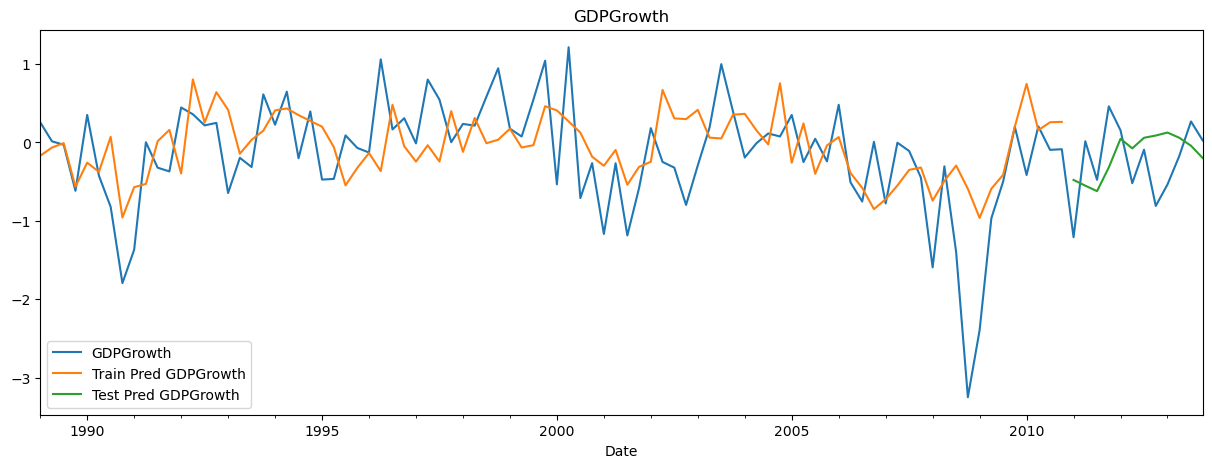

In [114]:
plot_cols = ['GDPGrowth','Train Pred GDPGrowth','Test Pred GDPGrowth']
df1.iloc[-100:][plot_cols].plot(figsize=(15,5));
plt.title('GDPGrowth')
plt.show()

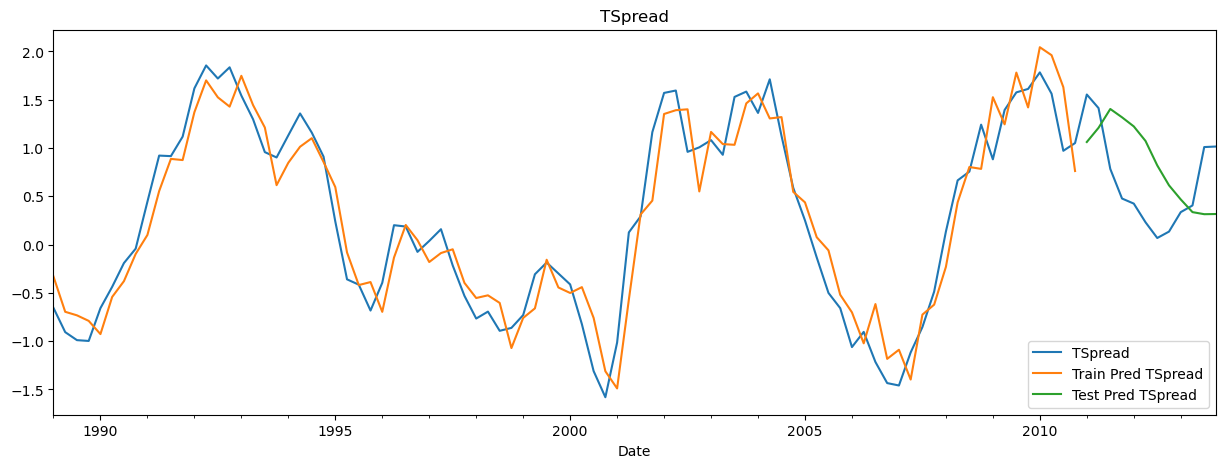

In [115]:
plot_cols = ['TSpread','Train Pred TSpread','Test Pred TSpread']
df1.iloc[-100:][plot_cols].plot(figsize=(15,5));
plt.title('TSpread')
plt.show()

- Difficult to tell us its better or worse than before for GDPGrowth
- For TSpread, in-sample predictions just lag the previous value. For forecast, it is much worse than before
- Now R^2 for train and test

In [116]:
y_pred = df1.loc[train_idx,'Train Pred GDPGrowth']
y_true = df1.loc[train_idx,'GDPGrowth']
y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]
print(f'GDPGrowth Train R^2: {r2_score(y_true,y_pred)}')

y_pred = df1.loc[test_idx,'Test Pred GDPGrowth']
y_true = df1.loc[test_idx,'GDPGrowth']
print(f'GDPGrowth Test R^2: {r2_score(y_true,y_pred)}')

GDPGrowth Train R^2: 0.29005914897389606
GDPGrowth Test R^2: -0.23961760567261248


- For both, R^2 is worse. In this case we can conclude VARMA is better than VAR (at least for the orders we selected)

# ARIMA econometrics (as baseline)
- Use ARIMA as a baseline for comparison

In [117]:
for col in cols:
    model = ARIMA(train[col],order=(p,0,q))
    res = model.fit()
    fcast = res.get_forecast(Ntest)
    y_train = df1.loc[train_idx,col]
    y_test = df1.loc[test_idx,col]
    print(f'{col} Train R^2: {r2_score(y_train,res.fittedvalues)}')
    print(f'{col} Test R^2: {r2_score(y_test,fcast.predicted_mean)}')

GDPGrowth Train R^2: 0.20569396813071605
GDPGrowth Test R^2: -0.8486466090265148
TSpread Train R^2: 0.8332486531721219
TSpread Test R^2: -2.996383469844483


- This time ARIMA does not outperform VARMA
    - R^2 score is worse for both train and test for both GDPGrowth and TSpread
- In this econometric case, we see that VARMA is useful and there could be some predictive value in looking across the two time series